# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

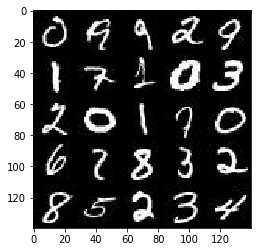

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

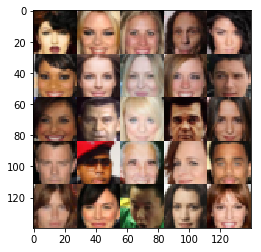

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
alpha=0.15 

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x(1 or 3)
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x128

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.dropout(x1,0.5) #Based on https://arxiv.org/pdf/1611.07004v1.pdf
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(x2,0.5)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x64 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(x3,0.5)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x32 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x(1 or 3) now
        
        out = tf.tanh(logits)
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate*2, beta1=beta1).minimize(g_loss, var_list=g_vars) 
                                #Learn generator with larger step
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learning_rate_var = model_inputs(data_shape[1], data_shape[2],  data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    losses = []
    print_every = 10
    show_every = 100
    n_images=25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                batch_images=batch_images*2 #go from -0.5 to 0.5 to -1 to 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                x=batch_images
                
                
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, learning_rate_var:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x, learning_rate_var:learning_rate})

                # Based on https://github.com/soumith/ganhacks
                # Using a large enough train set to avoid overfitting.
#                 train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
#                 train_loss_g = g_loss.eval({input_z: batch_z})
#                 while(train_loss_d>0.5):
#                     _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, learning_rate_var:learning_rate})
#                     train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                
#                 while(0.5<train_loss_g):
#                     _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x, learning_rate_var:learning_rate})
#                     train_loss_g = g_loss.eval({input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                steps+=1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5989... Generator Loss: 0.4944


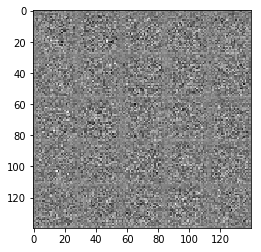

Epoch 1/2... Discriminator Loss: 0.4010... Generator Loss: 1.6588
Epoch 1/2... Discriminator Loss: 0.5499... Generator Loss: 1.6738
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 1.3604
Epoch 1/2... Discriminator Loss: 0.7190... Generator Loss: 1.1976
Epoch 1/2... Discriminator Loss: 0.4681... Generator Loss: 2.1739
Epoch 1/2... Discriminator Loss: 0.5795... Generator Loss: 1.6757
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 1.8198
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 2.1301


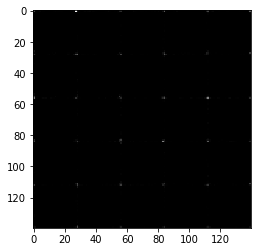

Epoch 1/2... Discriminator Loss: 0.5917... Generator Loss: 1.0960
Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 1.5870
Epoch 1/2... Discriminator Loss: 0.5431... Generator Loss: 1.5444
Epoch 1/2... Discriminator Loss: 0.5344... Generator Loss: 2.0111
Epoch 1/2... Discriminator Loss: 0.4982... Generator Loss: 1.5115
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 1.4499
Epoch 1/2... Discriminator Loss: 0.4815... Generator Loss: 1.9297
Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 1.0893
Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 1.7773
Epoch 1/2... Discriminator Loss: 0.6346... Generator Loss: 1.2228


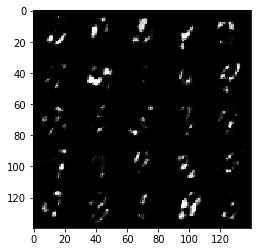

Epoch 1/2... Discriminator Loss: 0.6628... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 0.6566... Generator Loss: 1.1148
Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 1.4109
Epoch 1/2... Discriminator Loss: 0.7574... Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 0.5970... Generator Loss: 1.5125
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 2.5430
Epoch 1/2... Discriminator Loss: 0.5302... Generator Loss: 1.7997
Epoch 1/2... Discriminator Loss: 0.6343... Generator Loss: 1.3126
Epoch 1/2... Discriminator Loss: 0.6928... Generator Loss: 1.2398
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.1754


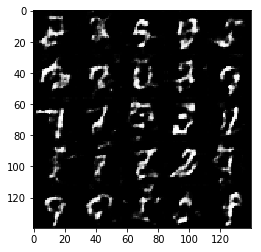

Epoch 1/2... Discriminator Loss: 0.5871... Generator Loss: 2.1522
Epoch 1/2... Discriminator Loss: 0.5841... Generator Loss: 2.7199
Epoch 1/2... Discriminator Loss: 0.5458... Generator Loss: 2.0806
Epoch 1/2... Discriminator Loss: 0.6998... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 1.1373
Epoch 1/2... Discriminator Loss: 0.4905... Generator Loss: 1.4648
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 3.1649
Epoch 1/2... Discriminator Loss: 0.6852... Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 0.6845... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.6840... Generator Loss: 2.2705


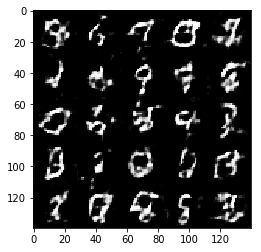

Epoch 1/2... Discriminator Loss: 0.5179... Generator Loss: 1.6010
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 0.9155
Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 1.7818
Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 1.5474
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 2.0359
Epoch 1/2... Discriminator Loss: 0.5651... Generator Loss: 1.3455
Epoch 1/2... Discriminator Loss: 0.6858... Generator Loss: 1.7426
Epoch 1/2... Discriminator Loss: 0.7475... Generator Loss: 1.9111
Epoch 1/2... Discriminator Loss: 0.8608... Generator Loss: 1.9156
Epoch 1/2... Discriminator Loss: 0.7270... Generator Loss: 1.7255


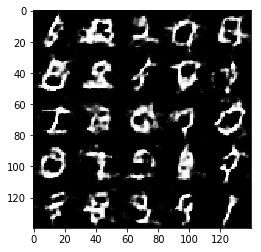

Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 1.6629
Epoch 1/2... Discriminator Loss: 0.7158... Generator Loss: 1.4668
Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 2.2711
Epoch 1/2... Discriminator Loss: 0.6208... Generator Loss: 1.6877
Epoch 1/2... Discriminator Loss: 0.7237... Generator Loss: 1.6203
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.4242
Epoch 1/2... Discriminator Loss: 0.6359... Generator Loss: 1.1739
Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 1.2968
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 2.8396
Epoch 1/2... Discriminator Loss: 0.6802... Generator Loss: 1.6520


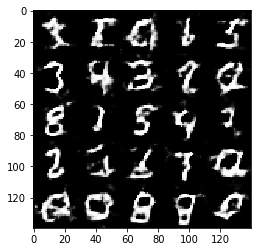

Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.1694
Epoch 1/2... Discriminator Loss: 0.8008... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 0.7643... Generator Loss: 0.9953
Epoch 1/2... Discriminator Loss: 0.6486... Generator Loss: 1.3999
Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 1.8712
Epoch 1/2... Discriminator Loss: 0.6040... Generator Loss: 1.2901
Epoch 1/2... Discriminator Loss: 0.7419... Generator Loss: 1.6894
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 2.5570
Epoch 1/2... Discriminator Loss: 0.4902... Generator Loss: 1.5283
Epoch 1/2... Discriminator Loss: 0.6775... Generator Loss: 1.7260


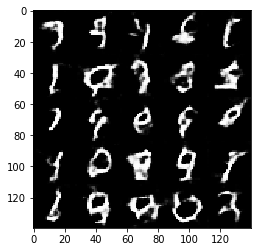

Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 1.3945
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.7643
Epoch 1/2... Discriminator Loss: 0.7089... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 0.6066... Generator Loss: 1.5812
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 1.4789
Epoch 1/2... Discriminator Loss: 0.6037... Generator Loss: 2.1370
Epoch 1/2... Discriminator Loss: 0.5402... Generator Loss: 1.9186
Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 1.7589
Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 0.6846... Generator Loss: 1.2442


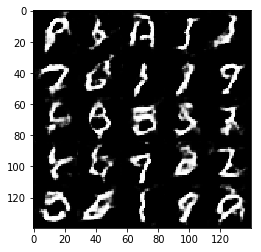

Epoch 1/2... Discriminator Loss: 0.7126... Generator Loss: 1.5312
Epoch 1/2... Discriminator Loss: 0.6220... Generator Loss: 1.3290
Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 1.7071
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 1.9423
Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 1.6800
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.8510
Epoch 1/2... Discriminator Loss: 0.5123... Generator Loss: 1.6683
Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 1.9310
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 1.5369


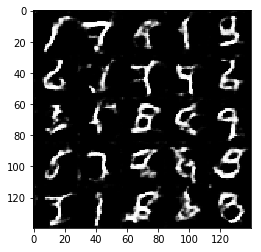

Epoch 1/2... Discriminator Loss: 0.5914... Generator Loss: 1.9823
Epoch 1/2... Discriminator Loss: 0.6575... Generator Loss: 2.0174
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 0.5093
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 2.2380


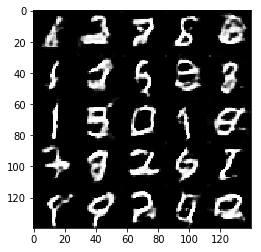

Epoch 2/2... Discriminator Loss: 0.4548... Generator Loss: 1.7106
Epoch 2/2... Discriminator Loss: 0.8073... Generator Loss: 1.9335
Epoch 2/2... Discriminator Loss: 0.8917... Generator Loss: 2.8829
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.7470
Epoch 2/2... Discriminator Loss: 0.6411... Generator Loss: 1.6449
Epoch 2/2... Discriminator Loss: 0.6728... Generator Loss: 2.2363
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 1.3903
Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 2.0472
Epoch 2/2... Discriminator Loss: 0.6246... Generator Loss: 1.3220
Epoch 2/2... Discriminator Loss: 0.6598... Generator Loss: 2.0578


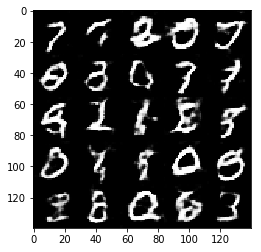

Epoch 2/2... Discriminator Loss: 0.5250... Generator Loss: 1.8983
Epoch 2/2... Discriminator Loss: 0.5771... Generator Loss: 2.5973
Epoch 2/2... Discriminator Loss: 0.6118... Generator Loss: 2.2092
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 2.6459
Epoch 2/2... Discriminator Loss: 0.6119... Generator Loss: 1.7288
Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 2.8141
Epoch 2/2... Discriminator Loss: 0.5359... Generator Loss: 1.4018
Epoch 2/2... Discriminator Loss: 0.5516... Generator Loss: 1.4804
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 1.7159


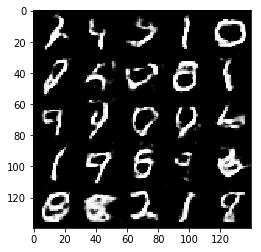

Epoch 2/2... Discriminator Loss: 1.0106... Generator Loss: 0.6619
Epoch 2/2... Discriminator Loss: 0.5949... Generator Loss: 2.0515
Epoch 2/2... Discriminator Loss: 0.6835... Generator Loss: 2.7817
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 0.6231... Generator Loss: 1.3904
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 2.2989
Epoch 2/2... Discriminator Loss: 0.5674... Generator Loss: 1.9113
Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.1034
Epoch 2/2... Discriminator Loss: 0.6571... Generator Loss: 1.8812
Epoch 2/2... Discriminator Loss: 0.6860... Generator Loss: 1.1121


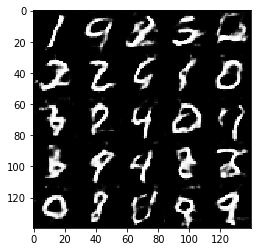

Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 2.3389
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 0.5358... Generator Loss: 2.3332
Epoch 2/2... Discriminator Loss: 0.5999... Generator Loss: 1.9334
Epoch 2/2... Discriminator Loss: 0.6470... Generator Loss: 2.1955
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 2.6389
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 1.2062
Epoch 2/2... Discriminator Loss: 0.5312... Generator Loss: 1.5061
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 0.5846


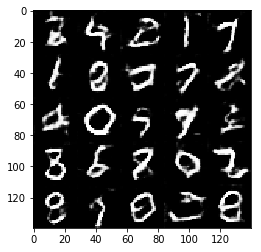

Epoch 2/2... Discriminator Loss: 0.4510... Generator Loss: 1.4371
Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 1.4972
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 1.3676
Epoch 2/2... Discriminator Loss: 0.5633... Generator Loss: 1.9376
Epoch 2/2... Discriminator Loss: 0.4916... Generator Loss: 2.3873
Epoch 2/2... Discriminator Loss: 0.5011... Generator Loss: 2.1342
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.3169
Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 1.5136
Epoch 2/2... Discriminator Loss: 0.4978... Generator Loss: 1.2289
Epoch 2/2... Discriminator Loss: 0.5533... Generator Loss: 2.5592


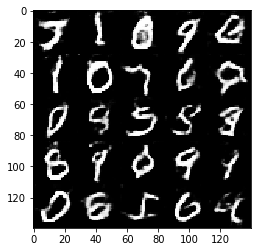

Epoch 2/2... Discriminator Loss: 0.5874... Generator Loss: 2.6698
Epoch 2/2... Discriminator Loss: 0.5563... Generator Loss: 1.3958
Epoch 2/2... Discriminator Loss: 0.9009... Generator Loss: 3.4026
Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 1.3243
Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 1.5512
Epoch 2/2... Discriminator Loss: 0.4700... Generator Loss: 1.5736
Epoch 2/2... Discriminator Loss: 0.5257... Generator Loss: 1.8479
Epoch 2/2... Discriminator Loss: 0.4846... Generator Loss: 1.8160
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 2.4953
Epoch 2/2... Discriminator Loss: 0.4786... Generator Loss: 2.5553


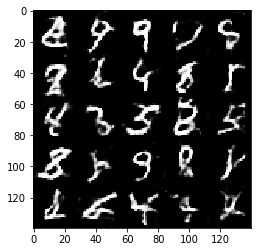

Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 2.8060
Epoch 2/2... Discriminator Loss: 0.4565... Generator Loss: 1.9119
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 3.3974
Epoch 2/2... Discriminator Loss: 0.4063... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.3464
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 2.4400
Epoch 2/2... Discriminator Loss: 0.5572... Generator Loss: 2.6154
Epoch 2/2... Discriminator Loss: 0.3727... Generator Loss: 2.2249
Epoch 2/2... Discriminator Loss: 0.3406... Generator Loss: 1.8256


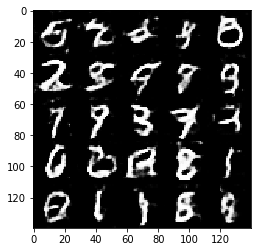

Epoch 2/2... Discriminator Loss: 0.5256... Generator Loss: 1.4653
Epoch 2/2... Discriminator Loss: 0.4176... Generator Loss: 1.6447
Epoch 2/2... Discriminator Loss: 0.6733... Generator Loss: 2.7961
Epoch 2/2... Discriminator Loss: 0.4676... Generator Loss: 2.3109
Epoch 2/2... Discriminator Loss: 0.3867... Generator Loss: 1.8464
Epoch 2/2... Discriminator Loss: 0.4811... Generator Loss: 1.9503
Epoch 2/2... Discriminator Loss: 0.4237... Generator Loss: 1.8979
Epoch 2/2... Discriminator Loss: 0.4740... Generator Loss: 2.2746
Epoch 2/2... Discriminator Loss: 0.4406... Generator Loss: 2.2463
Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 2.6416


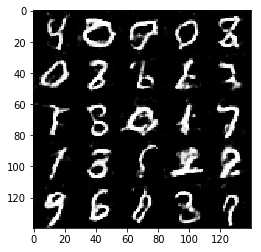

Epoch 2/2... Discriminator Loss: 0.6083... Generator Loss: 1.9379
Epoch 2/2... Discriminator Loss: 0.4456... Generator Loss: 2.4322
Epoch 2/2... Discriminator Loss: 0.3625... Generator Loss: 2.0735
Epoch 2/2... Discriminator Loss: 0.4792... Generator Loss: 1.5268
Epoch 2/2... Discriminator Loss: 0.5354... Generator Loss: 2.1813
Epoch 2/2... Discriminator Loss: 0.4778... Generator Loss: 2.7687
Epoch 2/2... Discriminator Loss: 0.3677... Generator Loss: 2.2034
Epoch 2/2... Discriminator Loss: 0.7605... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 0.4732... Generator Loss: 2.1770
Epoch 2/2... Discriminator Loss: 0.4989... Generator Loss: 2.5150


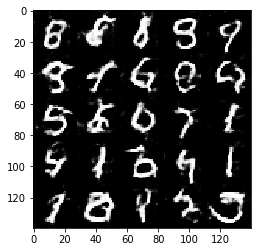

Epoch 2/2... Discriminator Loss: 0.5097... Generator Loss: 2.6865
Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 0.7073... Generator Loss: 0.9017


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.00015
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.7887


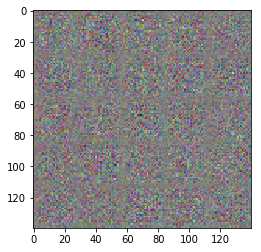

Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 1.8500
Epoch 1/1... Discriminator Loss: 0.1997... Generator Loss: 2.6715
Epoch 1/1... Discriminator Loss: 0.1652... Generator Loss: 2.7382
Epoch 1/1... Discriminator Loss: 0.1564... Generator Loss: 2.7667
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 2.0992
Epoch 1/1... Discriminator Loss: 0.2271... Generator Loss: 2.2878
Epoch 1/1... Discriminator Loss: 0.1415... Generator Loss: 3.1741
Epoch 1/1... Discriminator Loss: 0.1344... Generator Loss: 3.0443
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 2.7925
Epoch 1/1... Discriminator Loss: 0.1731... Generator Loss: 2.5208


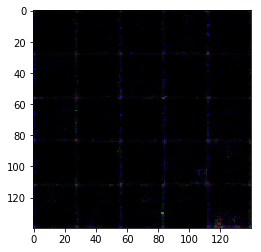

Epoch 1/1... Discriminator Loss: 0.2618... Generator Loss: 1.9037
Epoch 1/1... Discriminator Loss: 0.0827... Generator Loss: 3.1199
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 3.4052
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 3.4868
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 4.4561
Epoch 1/1... Discriminator Loss: 0.0406... Generator Loss: 4.5232
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 3.1723
Epoch 1/1... Discriminator Loss: 0.2264... Generator Loss: 7.4537
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 3.1547
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 3.7497


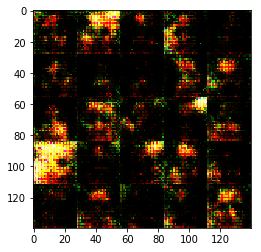

Epoch 1/1... Discriminator Loss: 0.0512... Generator Loss: 3.8352
Epoch 1/1... Discriminator Loss: 0.0325... Generator Loss: 4.2812
Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 5.4247
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 4.9751
Epoch 1/1... Discriminator Loss: 0.0130... Generator Loss: 4.8468
Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 4.7145
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 5.1233
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 4.9968
Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 5.0293
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 4.6689


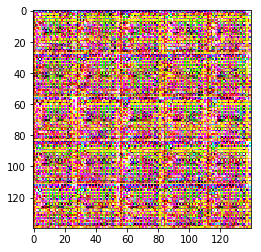

Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 4.5106
Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 4.5303
Epoch 1/1... Discriminator Loss: 0.0206... Generator Loss: 4.6369
Epoch 1/1... Discriminator Loss: 0.0399... Generator Loss: 4.5242
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 4.6821
Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 4.3366
Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 3.8730
Epoch 1/1... Discriminator Loss: 0.0585... Generator Loss: 6.7130
Epoch 1/1... Discriminator Loss: 0.1724... Generator Loss: 2.8926
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 3.1648


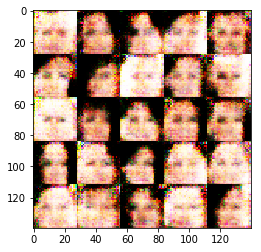

Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 1.8064
Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 2.1306
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 1.7482
Epoch 1/1... Discriminator Loss: 0.2967... Generator Loss: 2.9133
Epoch 1/1... Discriminator Loss: 0.2620... Generator Loss: 2.2397
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 1.8413
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 2.7348
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 2.3576
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 2.2625


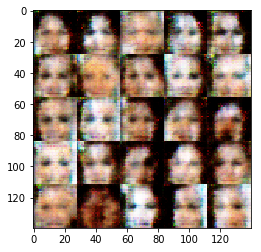

Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 1.7371
Epoch 1/1... Discriminator Loss: 0.2556... Generator Loss: 2.5971
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 1.6888
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 1.6366
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.5986
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 3.9082


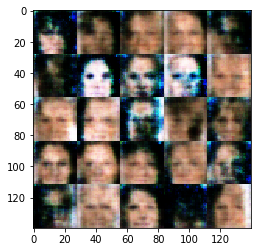

Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 2.2315
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.0973
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 2.4933
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.4075
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.7494
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 1.3572
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.3513


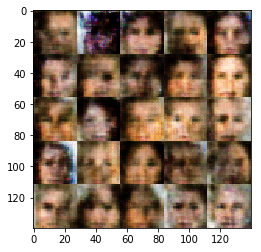

Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.2666
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.4767
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.4047
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.2136
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 2.0240
Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 1.9742


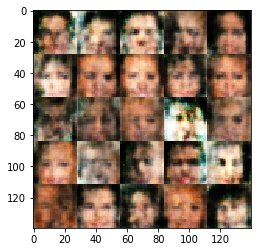

Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.2694
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.4843
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.2222


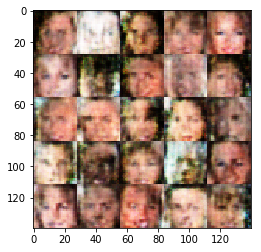

Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 1.7717
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.2714


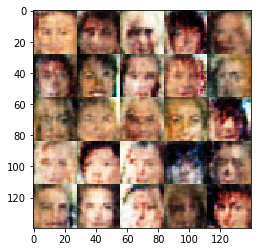

Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.4557
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.3142
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.2386
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.9413


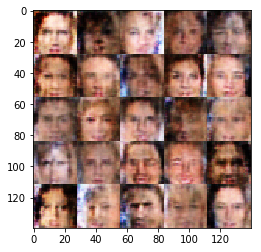

Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.2907
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.2234
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.1555


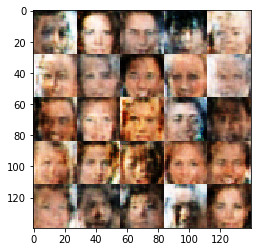

Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.6266
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.5755
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.3356
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.1450


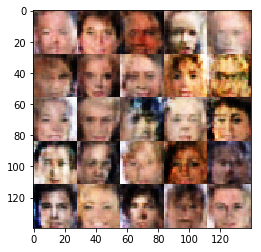

Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.3363
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.2233
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 0.9508


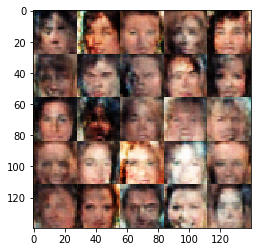

Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.0055


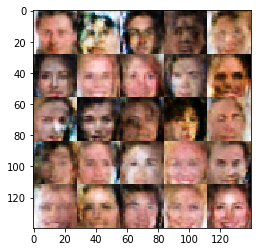

Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.3171
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0197


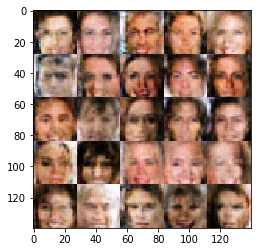

Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.2546
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.9947


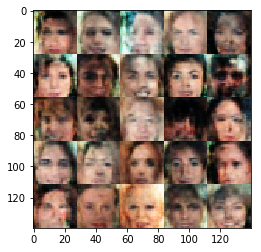

Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.9658


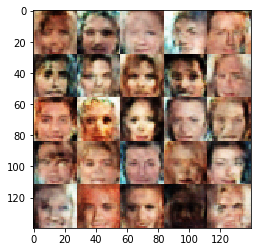

Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9430


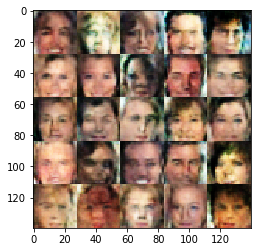

Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 0.9816


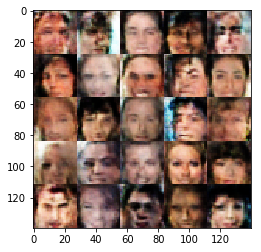

Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.1847


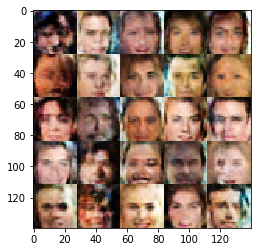

Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.1234
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.0085


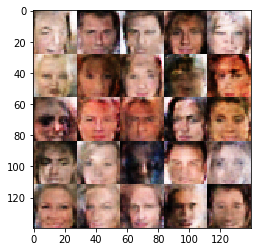

Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.4424


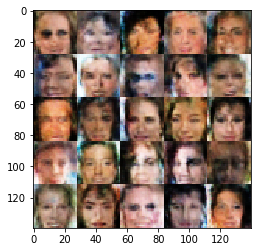

Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.2880


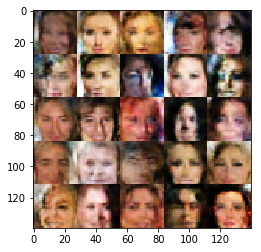

Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.7030


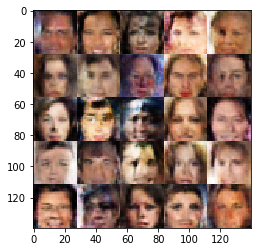

Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.0768


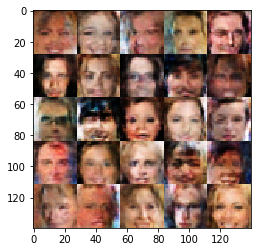

Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.9834


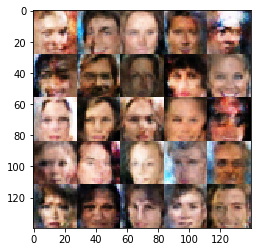

Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.5468
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.8590


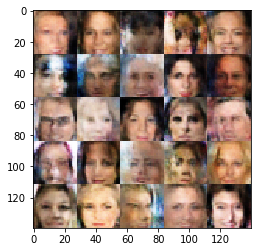

Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.2477
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.9543


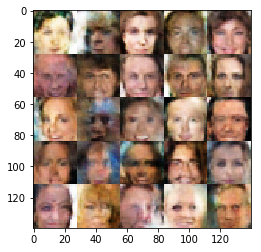

Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.0843


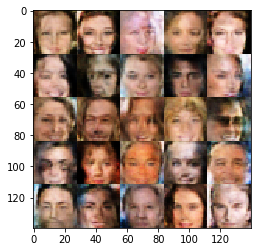

Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.1885


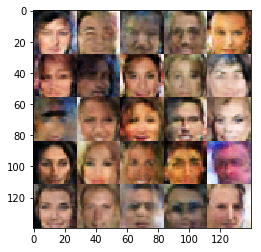

Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.9464


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.00015
beta1 = 0.5

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.